# Test new model

In [11]:
import torch
import torch.nn as nn 
from utils import get_mse_data, get_mse_train_loader

## Data

In [12]:
num_users, num_items, users_train, items_train, ratings_train, users_test, items_test, ratings_test, train_candidates, test_candidates = get_mse_data()

In [13]:
train_loader = get_mse_train_loader(users_train, items_train, ratings_train, shuffle=True)

In [14]:
len(train_loader)

98

## Model Config

In [15]:
from gcn.attention import AttMFiu
device = "cuda" if torch.cuda.is_available() else "cpu"
n_factors = 10
model = AttMFiu(num_users, num_items, n_factors)
model.to(device)
learning_rate, weight_decay = 0.01, 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)
loss_fn = nn.MSELoss()
print(f"device: {device}, n_factors: {n_factors}, learning_rate: {learning_rate}, weight_decay: {weight_decay}")

device: cuda, n_factors: 10, learning_rate: 0.01, weight_decay: 1e-05


## Train

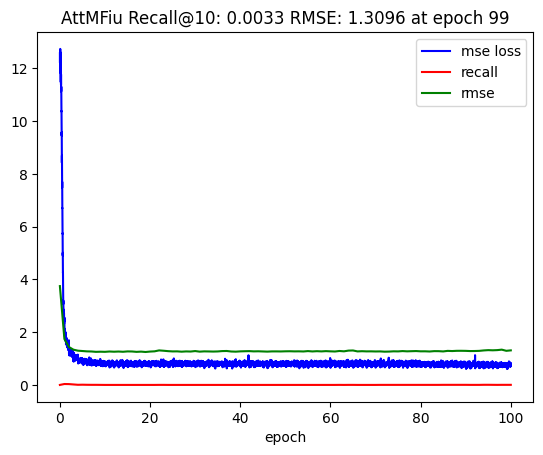

AttMFiu Recall@10: 0.0033 RMSE: 1.3096 at epoch 99


In [16]:
from gcn.train import evaluate_ranking, evaluate_rating
from gcn.visualize import Animator
ani = Animator()
num_epochs = 100
topk = 10
train_epoch_perc = []
train_loss = []
epoch_list = []
rmse_list = []
recall_list = []

with torch.no_grad():
    recall = evaluate_ranking(
        model,
        test_candidates,
        train_candidates,
        num_users,
        num_items,
        top_k = topk
    )
    recall_list.append(recall)
    rmse = evaluate_rating(
        model,
        users_test, 
        items_test, 
        ratings_test
    )
    rmse_list.append(rmse)
    epoch_list.append(0)

for epoch in range(num_epochs):
    for batch, values in enumerate(train_loader):
        users, items, ratings = values[0].to(device), values[1].to(device), values[2].to(device)
        # Forward pass
        scores = model(users, items)
        loss = loss_fn(scores, ratings.float())
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if batch % 64 == 0:
        train_epoch_perc.append((batch+1)/ len(train_loader) + epoch)
        train_loss.append(loss.item())
        print(f'step:{batch+1}/{len(train_loader)} epoch:{epoch}/{num_epochs} loss:{train_loss[-1]}')


    with torch.no_grad():
        recall = evaluate_ranking(
            model,
            test_candidates,
            train_candidates,
            num_users,
            num_items,
            top_k = topk
        )
        recall_list.append(recall)
        rmse = evaluate_rating(
            model,
            users_test, 
            items_test, 
            ratings_test
        )
        rmse_list.append(rmse)
        epoch_list.append(epoch+1)


    ani.clear()
    ani.ax.plot(train_epoch_perc, train_loss, color='b', label='mse loss')
    ani.ax.plot(epoch_list, recall_list, color='r', label='recall')
    ani.ax.plot(epoch_list, rmse_list, color='g', label='rmse')
    ani.ax.set_xlabel('epoch')
    ani.ax.legend()
    ani.ax.set_title(f'AttMFiu Recall@{topk}: {recall_list[-1]:.4f} RMSE: {rmse_list[-1]:.4f} at epoch {epoch}')
    ani.render()

    print(f'AttMFiu Recall@{topk}: {recall_list[-1]:.4f} RMSE: {rmse_list[-1]:.4f} at epoch {epoch}')

ani.close()

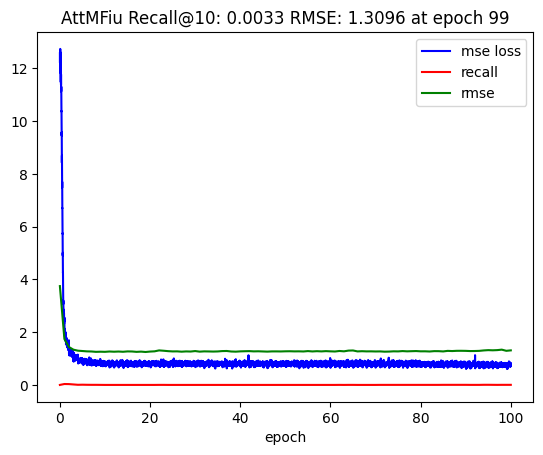

In [17]:
import matplotlib.pyplot as plt
plt.plot(train_epoch_perc, train_loss, color='b', label='mse loss')
plt.plot(epoch_list, recall_list, color='r', label='recall')
plt.plot(epoch_list, rmse_list, color='g', label='rmse')
plt.xlabel("epoch")
plt.legend()
plt.title(f'AttMFiu Recall@{topk}: {recall_list[-1]:.4f} RMSE: {rmse_list[-1]:.4f} at epoch {epoch}')
plt.show()

In [18]:
recall_list

[0.0,
 0.03442622950819672,
 0.03114754098360656,
 0.018032786885245903,
 0.004918032786885246,
 0.00819672131147541,
 0.004918032786885246,
 0.003278688524590164,
 0.003278688524590164,
 0.001639344262295082,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.001639344262295082,
 0.001639344262295082,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.001639344262295082,
 0.0,
 0.001639344262295082,
 0.001639344262295082,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.001639344262295082,
 0.001639344262295082,
 0.001639344262295082,
 0.001639344262295082,
 0.001639344262295082,
 0.001639344262295082,
 0.001639344262295082,
 0.001639344262295082,
 0.001639344262295082,
 0.001639344262295082,
 0.001639344262295082,
 0.001639344262295082,
 0.001639344262295082,
 0.001639344262295082,
 0.00327868852459

In [19]:
rmse_list

[3.7455976712639636,
 1.741284260299807,
 1.4377403887561953,
 1.3361752839427752,
 1.2976190202253879,
 1.2847530115006531,
 1.2717412873635772,
 1.267307481835861,
 1.2538423135684234,
 1.258636489038315,
 1.2543611265896888,
 1.2666011389714742,
 1.2586548632341759,
 1.2656160519130537,
 1.2564015501095969,
 1.2702116096850167,
 1.2673969815315034,
 1.253187312148928,
 1.2619927170871301,
 1.248166742672644,
 1.2642630324896098,
 1.2733481908267617,
 1.3084168727388594,
 1.2954933896089347,
 1.279635505411799,
 1.2698854392488415,
 1.2720532997618448,
 1.2600596003590105,
 1.269992826621755,
 1.2654139966855955,
 1.2834803544499986,
 1.2613332058971682,
 1.2717452243140097,
 1.2687350549428387,
 1.2644570224196336,
 1.2690313675553078,
 1.2825123685571278,
 1.2861728068210907,
 1.2665755387620274,
 1.2607686625802663,
 1.271787545761459,
 1.2769823875586817,
 1.2807969943972126,
 1.2714474814785959,
 1.274789805944217,
 1.2685146075840972,
 1.2624494957972703,
 1.270317890301256,
 1

In [20]:
# max(recall_list), min(rmse_list) 
print(f'AttMFiu Max Recall@{topk}: {max(recall_list):.4f} at epoch {recall_list.index(max(recall_list))}')
print(f'AttMFiu Min RMSE: {min(rmse_list):.4f} at epoch {rmse_list.index(min(rmse_list))}')

AttMFiu Max Recall@10: 0.0344 at epoch 1
AttMFiu Min RMSE: 1.2482 at epoch 19
